# Reserve and configure FABRIC resources for reproducing "Revisiting TCP Congestion Control Throughput Models & Fairness Properties at Scale"

## Set up your FABRIC environment

This assumes that you have already configured your FABRIC account and your Jupyter environment as described in [Hello, FABRIC](https://teaching-on-testbeds.github.io/blog/hello-fabric).

In [7]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [8]:
# !chmod 600 {fablib.get_bastion_key_filename()}
# !chmod 600 {fablib.get_default_slice_private_key_file()}

## Create and submit a slice

In [9]:
n_endpoints = 2
slice_name = "tcp_congestion_control_smart_nic" + fablib.get_bastion_username()
slice = fablib.new_slice(name=slice_name)

In [10]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")

You don't have a slice named tcp_congestion_control_smart_nicnm3833_0000195331 yet.
Continue to the next step to make one.


In [11]:
# slice.delete()

This cell will try to identify a site that has sufficient resources for your experiment. But, you should still check in the [FABRIC Portal](https://portal.fabric-testbed.net/resources/all) to make sure it is not in maintenance or out of service - if so, you should run the cell again until you get a site that is ready to use.

In [12]:
exp_requires = {'core': 2*n_endpoints*4+32, 'nic': 2*n_endpoints*1, 'connectx5': 1}
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_requires['core']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_requires['nic']) and
        (fablib.resources.get_component_available(site_name, 'SmartNIC-ConnectX-5') > 1.2*exp_requires['connectx5'])   ):
        break

fablib.show_site(site_name)

Name,KANS
State,Active
Address,"1100 Walnut Street,Kansas City,MO 64106"
Location,"(39.1004885, -94.5823448)"
PTP Capable,False
Hosts,3
CPUs,6
Cores Available,324
Cores Capacity,384
Cores Allocated,60
Ram Available,1312


'<pandas.io.formats.style.Styler object at 0x7ca514f77110>'

In [13]:
# this cell sets up the hosts
slice.add_node(name='router', site=site_name, cores=32, ram=256, disk=25, image='default_ubuntu_22')

sender_names = ["sender-"+str(i) for i in range(n_endpoints)]
for n in sender_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=10, image='default_ubuntu_22')
    
receive_names = ["receiver-"+str(i) for i in range(n_endpoints)]
for n in receive_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=10, image='default_ubuntu_22')

In [14]:
# this cell sets up the network links
nets = [
    {"name": "link-sender",    "nodes": sender_names,  "idx": 0},
    {"name": "link-receiver",  "nodes": receive_names, "idx": 1}
]

router_iface = slice.get_node('router').add_component(model="NIC_ConnectX_5", name='link').get_interfaces()

for n in nets:
    ifaces = [slice.get_node(node).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] for node in n['nodes'] ] + [router_iface[n["idx"]]]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

When everything is ready, submit the slice and wait for it to get to "StableOK" state.  You can also see the state of your slice on the browser-based interface at https://portal.fabric-testbed.net/experiments#slices.

In case of an error, you can modify the slice name in the first cell of the "Create and submit a slice" section, to try again with a new slice (different name). Then, return to this cell and click Run > Run All Above Selected Cell. Finally, re-run the `slice.submit()` cell.

In [15]:
slice.submit()


Retry: 13, Time: 344 sec


ID,913d1e4a-6c94-446d-8e83-098e98540f38
Name,tcp_congestion_control_smart_nicnm3833_0000195331
Lease Expiration (UTC),2024-08-02 19:19:12 +0000
Lease Start (UTC),2024-08-01 19:19:12 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
99fe8378-9548-4b84-9cb8-b8ea94187ece,receiver-0,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe2f:a7f9,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe2f:a7f9,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
82ccfa07-db0b-40bd-bb9e-8005493bc8e5,receiver-1,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fee7:ca36,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fee7:ca36,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6381516a-ea78-404a-992a-48a6507a8cd0,router,32,256,100,default_ubuntu_22,qcow2,kans-w3.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe9c:80c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe9c:80c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
10ba8d2b-d9ad-4e4c-999c-862551ec7f3a,sender-0,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe6e:916a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe6e:916a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
e860a87a-77aa-49eb-a561-a3209227dc83,sender-1,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe52:5f5e,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe52:5f5e,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
dfcd65ab-d096-4711-9bdc-d90af8611a81,link-receiver,L2,L2Bridge,KANS,None,None,Active,
587cbd1b-80f5-4bdd-9c0e-a8578dc58b8e,link-sender,L2,L2Bridge,KANS,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
router-link-p1,p1,router,link-sender,25,config,,E8:EB:D3:24:F3:0E,enp7s0np0,enp7s0np0,fe80::eaeb:d3ff:fe24:f30e,1,TwentyFiveGigE0/0/0/10/0
router-link-p2,p2,router,link-receiver,25,config,,E8:EB:D3:24:F3:0F,enp8s0np0,enp8s0np0,fe80::eaeb:d3ff:fe24:f30f,1,TwentyFiveGigE0/0/0/10/1
sender-0-link-sender-p1,p1,sender-0,link-sender,100,config,,4E:4B:3E:60:D6:43,enp7s0,enp7s0,fe80::4c4b:3eff:fe60:d643,6,HundredGigE0/0/0/5
sender-1-link-sender-p1,p1,sender-1,link-sender,100,config,,4E:36:44:38:0E:B5,enp7s0,enp7s0,fe80::4c36:44ff:fe38:eb5,6,HundredGigE0/0/0/5
receiver-0-link-receiver-p1,p1,receiver-0,link-receiver,100,config,,52:2F:48:AF:66:52,enp7s0,enp7s0,fe80::502f:48ff:feaf:6652,6,HundredGigE0/0/0/5
receiver-1-link-receiver-p1,p1,receiver-1,link-receiver,100,config,,52:BF:05:1D:E7:6D,enp7s0,enp7s0,fe80::50bf:5ff:fe1d:e76d,6,HundredGigE0/0/0/5



Time to print interfaces 368 seconds


'913d1e4a-6c94-446d-8e83-098e98540f38'

In [20]:
# slice.delete()

## Configure resources

In [16]:
slice.get_state()

'StableOK'

In [17]:
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

Bring up all of the network interfaces:

In [18]:
for iface in slice.get_interfaces():
    iface.ip_link_up()

Assign addresses to router interfaces and enable forwarding:

In [19]:
from ipaddress import ip_address, IPv4Address, IPv4Network

if_sender = slice.get_interface('router-link-p1')
if_sender.ip_addr_add(addr="10.10.1.1", subnet=IPv4Network("10.10.1.0/24"))
if_receive = slice.get_interface('router-link-p2')
if_receive.ip_addr_add(addr="10.10.2.1", subnet=IPv4Network("10.10.2.0/24"))

slice.get_node(name='router').execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1


('net.ipv4.ip_forward = 1\n', '')

Assign addresses to host (sender and receiver) interfaces and set up routes:

In [20]:
for i in range(n_endpoints):
    if_name = slice.get_interface('sender-' + str(i) + '-link-sender-p1')
    if_name.ip_addr_add(addr="10.10.1.1" + str(i) , subnet=IPv4Network("10.10.1.0/24"))
    slice.get_node(name='sender-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.2.0/24"), gateway="10.10.1.1")
    
for i in range(n_endpoints):
    if_name = slice.get_interface('receiver-' + str(i) + '-link-receiver-p1')
    if_name.ip_addr_add(addr="10.10.2.1" + str(i) , subnet=IPv4Network("10.10.2.0/24"))
    slice.get_node(name='receiver-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.1.0/24"), gateway="10.10.2.1")

Also install `iperf3` on sender and receiver hosts:

In [21]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_endpoints)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_endpoints)]

In [22]:
for n in sender_nodes:
    n.execute_thread("sudo apt update; sudo apt -y install iperf3")
for n in receiver_nodes:
    n.execute_thread("sudo apt update; sudo apt -y install iperf3")

In [23]:
# slice.delete()

In [24]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

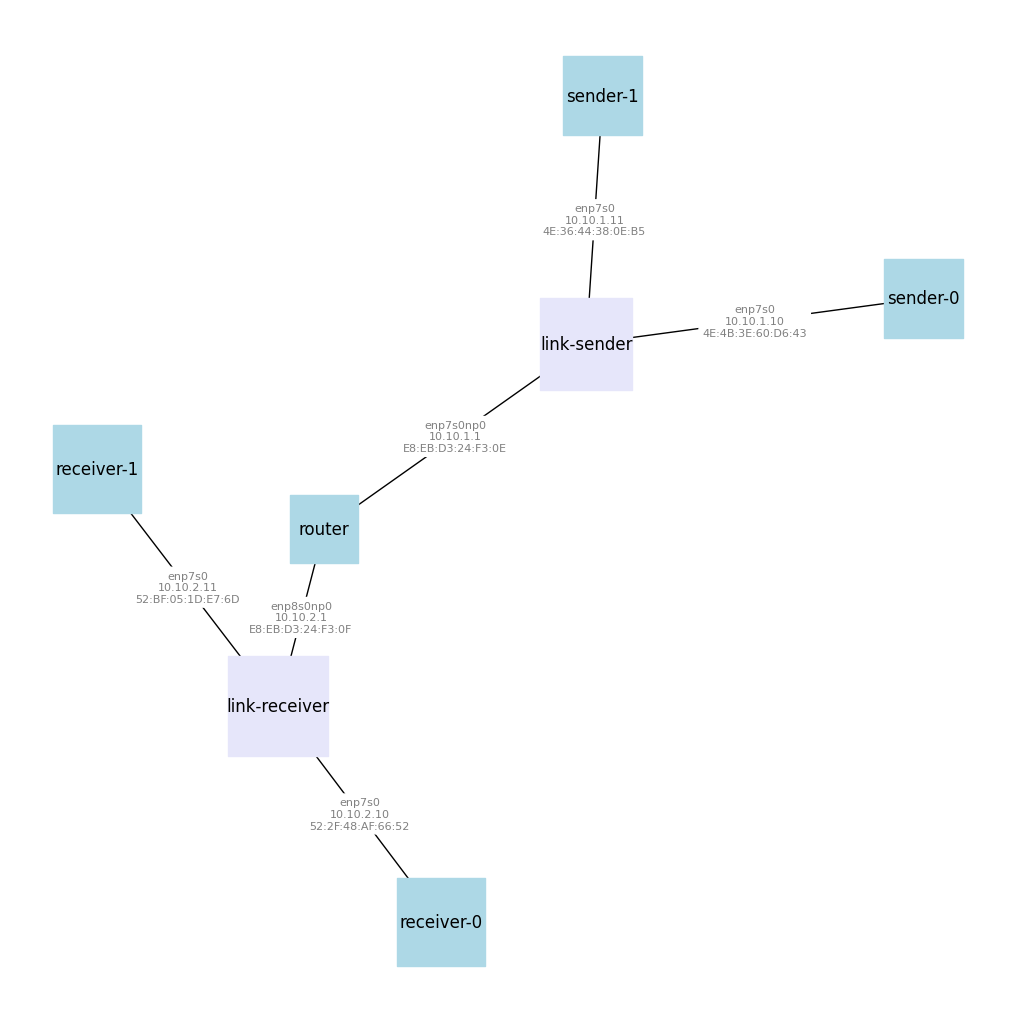

In [25]:
import networkx as nx
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=1)  # Adjust the 'k' value to space out the nodes

nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G, 'label'),
                             font_color='gray', font_size=8, rotate=False)

plt.show()


#### Extend slice for one week

In [26]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)


Retry: 1, Time: 81 sec


ID,913d1e4a-6c94-446d-8e83-098e98540f38
Name,tcp_congestion_control_smart_nicnm3833_0000195331
Lease Expiration (UTC),2024-08-07 19:27:40 +0000
Lease Start (UTC),2024-08-01 19:19:12 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
99fe8378-9548-4b84-9cb8-b8ea94187ece,receiver-0,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe2f:a7f9,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe2f:a7f9,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
82ccfa07-db0b-40bd-bb9e-8005493bc8e5,receiver-1,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fee7:ca36,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fee7:ca36,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6381516a-ea78-404a-992a-48a6507a8cd0,router,32,256,100,default_ubuntu_22,qcow2,kans-w3.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe9c:80c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe9c:80c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
10ba8d2b-d9ad-4e4c-999c-862551ec7f3a,sender-0,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe6e:916a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe6e:916a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
e860a87a-77aa-49eb-a561-a3209227dc83,sender-1,4,32,10,default_ubuntu_22,qcow2,kans-w1.fabric-testbed.net,KANS,ubuntu,2001:400:a100:3060:f816:3eff:fe52:5f5e,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe52:5f5e,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
dfcd65ab-d096-4711-9bdc-d90af8611a81,link-receiver,L2,L2Bridge,KANS,None,None,Active,
587cbd1b-80f5-4bdd-9c0e-a8578dc58b8e,link-sender,L2,L2Bridge,KANS,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
router-link-p1,p1,router,link-sender,25,config,,E8:EB:D3:24:F3:0E,enp7s0np0,enp7s0np0,10.10.1.1,1,TwentyFiveGigE0/0/0/10/0
router-link-p2,p2,router,link-receiver,25,config,,E8:EB:D3:24:F3:0F,enp8s0np0,enp8s0np0,10.10.2.1,1,TwentyFiveGigE0/0/0/10/1
sender-0-link-sender-p1,p1,sender-0,link-sender,100,config,,4E:4B:3E:60:D6:43,enp7s0,enp7s0,10.10.1.10,6,HundredGigE0/0/0/5
sender-1-link-sender-p1,p1,sender-1,link-sender,100,config,,4E:36:44:38:0E:B5,enp7s0,enp7s0,10.10.1.11,6,HundredGigE0/0/0/5
receiver-0-link-receiver-p1,p1,receiver-0,link-receiver,100,config,,52:2F:48:AF:66:52,enp7s0,enp7s0,10.10.2.10,6,HundredGigE0/0/0/5
receiver-1-link-receiver-p1,p1,receiver-1,link-receiver,100,config,,52:BF:05:1D:E7:6D,enp7s0,enp7s0,10.10.2.11,6,HundredGigE0/0/0/5



Time to print interfaces 105 seconds


In [27]:
slice.update()
_ = slice.show()

ID,913d1e4a-6c94-446d-8e83-098e98540f38
Name,tcp_congestion_control_smart_nicnm3833_0000195331
Lease Expiration (UTC),2024-08-07 19:27:40 +0000
Lease Start (UTC),2024-08-01 19:19:12 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


## Check network capacity

We should get close to 25 Gbps (probably more like 23 Gbps because of protocol overhead) through the router.

First, make sure there is no rate limiting at the router - don't worry if you get an error message, this just means there was already no rate limiting.

In [7]:
router_node.execute("sudo tc qdisc del dev " + router_egress_name + " root")

('', '')

Now start the `iperf3` flows:

In [8]:
for n in receiver_nodes:
    n.execute("iperf3 -s -1 -D --logfile validate.dat")

In [9]:
import time
for n in sender_nodes:
    n.execute_thread("iperf3 -t 60 -P 10 -c 10.10.2.1$(hostname | cut -d'-' -f2)")
time.sleep(65)

In [10]:
tputs = []
for n in receiver_nodes:
    (nout, nerr) = n.execute("tail --lines=2 validate.dat | grep receiver | awk '{print $6}'")
    tputs.append(float(nout.strip()))
print("Sum throughput is: %f Gbps" % sum(tputs))

2.91
6.05
Sum throughput is: 8.960000 Gbps


A single pair of endpoints should be able to get about 10 Gbps, possibly higher.

In [28]:
receiver_nodes[0].execute("iperf3 -s -1 -f g -D")
sender_nodes[0].execute("iperf3 -t 60 -i 60 -P 10 -c 10.10.2.1$(hostname | cut -d'-' -f2)")

Connecting to host 10.10.2.10, port 5201
[  4] local 10.10.1.10 port 34552 connected to 10.10.2.10 port 5201
[  6] local 10.10.1.10 port 34560 connected to 10.10.2.10 port 5201
[  8] local 10.10.1.10 port 34562 connected to 10.10.2.10 port 5201
[ 10] local 10.10.1.10 port 34568 connected to 10.10.2.10 port 5201
[ 12] local 10.10.1.10 port 34574 connected to 10.10.2.10 port 5201
[ 14] local 10.10.1.10 port 34578 connected to 10.10.2.10 port 5201
[ 16] local 10.10.1.10 port 34586 connected to 10.10.2.10 port 5201
[ 18] local 10.10.1.10 port 34600 connected to 10.10.2.10 port 5201
[ 20] local 10.10.1.10 port 34604 connected to 10.10.2.10 port 5201
[ 22] local 10.10.1.10 port 34612 connected to 10.10.2.10 port 5201
[ ID] Interval           Transfer     Bandwidth       Retr  Cwnd
[  4]   0.00-60.00  sec  7.24 GBytes  1.04 Gbits/sec  1907   1.65 MBytes       
[  6]   0.00-60.00  sec  4.91 GBytes   703 Mbits/sec  1544    795 KBytes       
[  8]   0.00-60.00  sec  6.59 GBytes   943 Mbits/sec  

('Connecting to host 10.10.2.10, port 5201\n[  4] local 10.10.1.10 port 34552 connected to 10.10.2.10 port 5201\n[  6] local 10.10.1.10 port 34560 connected to 10.10.2.10 port 5201\n[  8] local 10.10.1.10 port 34562 connected to 10.10.2.10 port 5201\n[ 10] local 10.10.1.10 port 34568 connected to 10.10.2.10 port 5201\n[ 12] local 10.10.1.10 port 34574 connected to 10.10.2.10 port 5201\n[ 14] local 10.10.1.10 port 34578 connected to 10.10.2.10 port 5201\n[ 16] local 10.10.1.10 port 34586 connected to 10.10.2.10 port 5201\n[ 18] local 10.10.1.10 port 34600 connected to 10.10.2.10 port 5201\n[ 20] local 10.10.1.10 port 34604 connected to 10.10.2.10 port 5201\n[ 22] local 10.10.1.10 port 34612 connected to 10.10.2.10 port 5201\n[ ID] Interval           Transfer     Bandwidth       Retr  Cwnd\n[  4]   0.00-60.00  sec  7.24 GBytes  1.04 Gbits/sec  1907   1.65 MBytes       \n[  6]   0.00-60.00  sec  4.91 GBytes   703 Mbits/sec  1544    795 KBytes       \n[  8]   0.00-60.00  sec  6.59 GBytes  

## Check network delay

We should get sub-ms latency across the router.

In [30]:
for n in sender_nodes:
    n.execute("ping -c 5 10.10.2.1$(hostname | cut -d'-' -f2) | grep rtt")

rtt min/avg/max/mdev = 10.128/10.172/10.273/0.137 ms
rtt min/avg/max/mdev = 10.120/10.184/10.341/0.102 ms
